# ニューラルネットワークの学習

訓練データから最適な重みパラメータの値を自動で獲得することを目指す

## 損失関数

### 2 乗和誤差

$$ E = \frac{1}{2} \sum_{k} (y_k - t_k)^2 $$

In [3]:
import numpy as np
def mean_squared_error(y, t):
    return 0.5 * np.sum((y - t) ** 2)

In [6]:
# index:2 を正解とする
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
mean_squared_error(np.array(t), np.array(y))

0.097500000000000031

In [7]:
# index:7 を正解とする
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
mean_squared_error(np.array(t), np.array(y))

0.59750000000000003

### 交差エントロピー誤差

$$ E = -\sum_{k} t_k \log{y_k} $$

In [8]:
def cross_entropy_error(y, t):
    delta = 1e-7 # log(0) でエラーになるのを防止するために、小さな値と足し合わせて log る
    return -np.sum(t * np.log(y + delta))

In [12]:
# index:2 を正解とする
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.51082545709933802

In [11]:
# index:7 を正解とする
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.3025840929945458

### ミニバッチ学習

訓練データすべての損失関数の和をもとめたい

$$ E = - \frac{1}{N} \sum_{n} \sum_{k} {t_{n\ k} \log{y_{n\ k}}} $$

単純に交差エントロピー誤差を N 個分足し合わせた後、N で割って正規化を行う

In [31]:
from sklearn.datasets import fetch_mldata
from PIL import Image
import matplotlib.pylab as plt
%matplotlib inline
mnist = fetch_mldata('MNIST original')

In [32]:
train_size = mnist.data.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = mnist.data[batch_mask]
t_batch = mnist.target[batch_mask]

In [33]:
def img_show(img):
    pil_img = Image.fromarray(np.uint8(img))
    plt.imshow(np.array(pil_img))

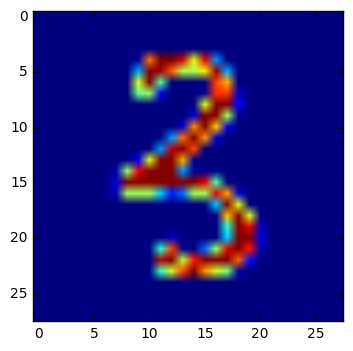

In [39]:
# img_show(x_batch[1].reshape(28, 28))
img_show(x_batch[9].reshape(28, 28))

In [46]:
# バッチ対応版の交差エントロピー誤差の実装
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size

## 数値微分

In [49]:
# わるい実装例
def numerical_diff(f, x):
    h = 10e-50
    return (f(x+h) - f(x)) / h

In [50]:
np.float32(10e-50)
# 丸め誤差により 0 になってしまう

0.0

In [52]:
# 中心差分
def numerical_diff(f, x):
    h = 1e-4
    # 数値微分
    return (f(x+h) - f(x-h)) / (2*h)

$$ y = 0.01 x^2 + 0.1 x $$ 

In [53]:
def function_1(x):
    return 0.01 * x ** 2 + 0.1 * x

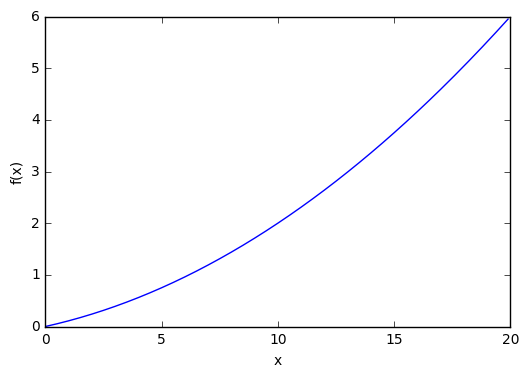

In [55]:
x = np.arange(0.0, 20.0, 0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x, y)
plt.show()

In [56]:
numerical_diff(function_1, 5)

0.1999999999990898

In [58]:
numerical_diff(function_1, 10)

0.2999999999986347

### 偏微分

$$ f(x_0, x_1) = x_0^2 + x_1^2 $$

In [59]:
def function_2(x):
    return np.sum(x**2)

In [60]:
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

In [61]:
numerical_diff(function_tmp1, 3.0)

6.00000000000378

## 勾配

$$ (\frac{\partial f}{\partial x_0}, \frac{\partial f}{\partial x_1}) $$

In [78]:
def _numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x) # x と同じ形状の配列を生成
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h)
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
    return grad

In [79]:
def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient(f, x)
        
        return grad

In [80]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([ 6.,  8.])

In [81]:
def function_2(x):
    if x.ndim == 1:
        return np.sum(x**2)
    else:
        return np.sum(x**2, axis=1)

In [82]:
x0 = np.arange(-2, 2.5, 0.25)
x1 = np.arange(-2, 2.5, 0.25)
X, Y = np.meshgrid(x0, x1)

X = X.flatten()
Y = Y.flatten()

grad = numerical_gradient(function_2, np.array([X, Y]) )

/home/mitake/lda/jawiki/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


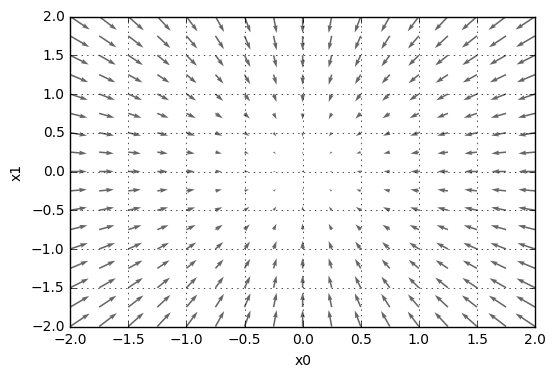

In [83]:
plt.figure()
plt.quiver(X, Y, -grad[0], -grad[1],  angles="xy",color="#666666")#,headwidth=10,scale=40,color="#444444")
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('x0')
plt.ylabel('x1')
plt.grid()
plt.legend()
plt.draw()
plt.show()